# COSE474-2024F: Deep Learning HW2

### 2021320011 유지연

## 7.1 From Fully Connected Layers to Convolutions (No Code)

## 7.2 Convolutions for Images

In [1]:
import torch
from torch import nn
from d2l import torch as d2l

### 7.2.1 The Cross-Correlation Operation

In [15]:
def corr2d(X,K):
    """Compute 2D cross-correlation"""
    h, w = K.shape
    #print(X.shape) -> torch.Size([3,3])
    Y = torch.zeros((X.shape[0]-h+1, X.shape[1]-w+1))
    for i in range(Y.shape[0]):
        for j in range(Y.shape[1]):
            Y[i, j] = (X[i:i+h, j:j+w] * K).sum()
    return Y

In [16]:
X = torch.tensor([[0.0, 1.0, 2.0], [3.0, 4.0, 5.0], [6.0, 7.0, 8.0]])
K = torch.tensor([[0.0, 1.0], [2.0, 3.0]])
corr2d(X, K)

tensor([[19., 25.],
        [37., 43.]])

### 7.2.2 Convolutional Layers

In [17]:
class Conv2D(nn.Module):
    def __init__(self, kernel_size):
        super().__init__()
        self.weight = nn.Parameter(torch.rand(kernel_size))
        self.bias = nn.Parameter(torch.zeros(1))

    def forward(self, x):
        return corr2d(x, self.weight) + self.bias

### 7.2.3 Object Edge Detection in Images

In [19]:
X = torch.ones((6, 8))
X[:, 2:6] = 0
X

tensor([[1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1.]])

In [20]:
K = torch.tensor([[1.0, -1.0]])

In [23]:
Y = corr2d(X, K)
Y
# we detect for 1 the edge from white to black and for -1 the edge from black to white

tensor([[ 0.,  1.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  1.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  1.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  1.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  1.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  1.,  0.,  0.,  0., -1.,  0.]])

In [24]:
corr2d(X.t(), K)

tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])

### 7.2.4 Learning a Kernel

In [29]:
# Construct a two-dimensional convolutional layer with 1 output channel and a
# kernel of shape (1,2). For the sake of simplicity, we ignore the bias here
conv2d = nn.LazyConv2d(1, kernel_size=(1,2), bias=False)

# The two-dimensional convolutional layer uses four-dimensional input and
# output in the format of (example, channel, height, width), where the batch
# size (number of examples in the batch) and the number of channels are both 1
X = X.reshape((1, 1, 6, 8))
Y = Y.reshape((1, 1, 6, 7))
lr = 3e-2 # learning rate

for i in range(10):
    Y_hat = conv2d(X)
    l = (Y_hat - Y) ** 2
    conv2d.zero_grad()
    l.sum().backward()
    # Update the kernel
    conv2d.weight.data[:] -= lr * conv2d.weight.grad
    if (i+1) % 2 == 0:
        print(f'epoch {i + 1}, loss {l.sum():.3f}')

epoch 2, loss 14.675
epoch 4, loss 4.458
epoch 6, loss 1.566
epoch 8, loss 0.598
epoch 10, loss 0.237


In [33]:
conv2d.weight.data.reshape((1, 2))
# K = torch.tensor([[1.0, -1.0]])

tensor([[ 0.9997, -1.0003]])

## 7.3 Padding and Stride

In [34]:
import torch
from torch import nn

### 7.3.1 Padding

In [35]:
# We define a helper function to calculate convolutions. It initializes the
# convolutional layer weights and performs corresponding dimensionality
# elevations and reductions on the input and output
def comp_conv2d(conv2d, X):
    # (1, 1) indicates that batch size and the number of channels are both 1
    X = X.reshape((1,1) + X.shape)
    Y = conv2d(X)
    # Strip the first two dimensions: examples and channels
    return Y.reshape(Y.shape[2:])

# 1 row and column is padded on either side, so a toal of 2 rows or columns are added
conv2d = nn.LazyConv2d(1, kernel_size=3, padding=1)
X = torch.rand(size=(8,8))
comp_conv2d(conv2d, X).shape

torch.Size([8, 8])

In [36]:
# We use a convolution kernel with height 5 and width 3.
# The padding on either side of the height and width are 2 and 1, respectively
conv2d = nn.LazyConv2d(1, kernel_size=(5,3), padding=(2,1))
comp_conv2d(conv2d, X).shape

torch.Size([8, 8])

### 7.3.2 Stride

In [37]:
conv2d = nn.LazyConv2d(1, kernel_size=3, padding=1, stride=2)
comp_conv2d(conv2d, X).shape

torch.Size([4, 4])

In [38]:
conv2d = nn.LazyConv2d(1, kernel_size=(3, 5), padding=(0, 1), stride=(3, 4))
comp_conv2d(conv2d, X).shape

torch.Size([2, 2])

## 7.4 Multiple Input and Multiple Output Channels

In [46]:
import torch
from d2l import torch as d2l

### 7.4.1 Multiple Input Channels

In [49]:
def corr2d_multi_in(X, K):
    # Iterate through the 0th dimenstion (channel) of K first, then add them up
    return sum(d2l.corr2d(x, k) for x, k in zip(X,K))

In [50]:
X = torch.tensor([[[0.0, 1.0, 2.0], [3.0, 4.0, 5.0], [6.0, 7.0, 8.0]],
               [[1.0, 2.0, 3.0], [4.0, 5.0, 6.0], [7.0, 8.0, 9.0]]])
K = torch.tensor([[[0.0, 1.0], [2.0, 3.0]], [[1.0, 2.0], [3.0, 4.0]]])

corr2d_multi_in(X, K)

tensor([[ 56.,  72.],
        [104., 120.]])

### 7.4.2 Multiple Ouput Channels

In [51]:
def corr2d_multi_in_out(X, K):
    # Iterate through the 0th dimenstion of K, and each time,
    # perform cross-correlation operations with input X.
    # All of the results are stacked together
    return torch.stack([corr2d_multi_in(X, k) for k in K], 0)

In [52]:
K = torch.stack((K, K + 1, K + 2), 0)
K.shape

torch.Size([3, 2, 2, 2])

In [53]:
corr2d_multi_in_out(X, K)

tensor([[[ 56.,  72.],
         [104., 120.]],

        [[ 76., 100.],
         [148., 172.]],

        [[ 96., 128.],
         [192., 224.]]])

### 7.4.3 1X1 Convolutional Layer

In [60]:
def corr2d_multi_in_out_1x1(X, K):
    c_i, h, w = X.shape
    c_o = K.shape[0]
    X = X.reshape((c_i, h * w))
    K = K.reshape((c_o, c_i))
    #Matrix multiplication in the fully connected layer
    Y = torch.matmul(K, X)
    return Y.reshape((c_o, h, w))

In [61]:
X = torch.normal(0, 1, (3, 3, 3))
K = torch.normal(0, 1, (2, 3, 1, 1))
Y1 = corr2d_multi_in_out_1x1(X, K)
Y2 = corr2d_multi_in_out(X, K)
assert float(torch.abs(Y1 - Y2).sum()) < 1e-6

## 7.5 Pooling

### 7.5.1 Maximum Pooling and Average Pooling

In [65]:
def pool2d(X, pool_size, mode="max"):
    p_h, p_w = pool_size
    Y = torch.zeros((X.shape[0] - p_h + 1, X.shape[1] - p_w + 1))
    for i in range(Y.shape[0]):
        for j in range(Y.shape[1]):
            if mode == "max":
                Y[i, j] = X[i:i+p_h, j:j+p_w].max()
            elif mode == "avg":
                Y[i, j] = X[i:i+p_h, j:j+p_w].mean()
    return Y

In [66]:
X = torch.tensor([[0.0, 1.0, 2.0], [3.0, 4.0, 5.0], [6.0, 7.0, 8.0]])
pool2d(X, (2, 2))

tensor([[4., 5.],
        [7., 8.]])

In [67]:
pool2d(X, (2, 2), 'avg')

tensor([[2., 3.],
        [5., 6.]])

### 7.5.2 Padding and Stride

In [74]:
X = torch.arange(16, dtype=torch.float32).reshape((1, 1, 4, 4))
X

tensor([[[[ 0.,  1.,  2.,  3.],
          [ 4.,  5.,  6.,  7.],
          [ 8.,  9., 10., 11.],
          [12., 13., 14., 15.]]]])

In [75]:
pool2d = nn.MaxPool2d(3)
# Pooling has no model parameters, hence it needs no initialization
pool2d(X)

tensor([[[[10.]]]])

In [76]:
pool2d = nn.MaxPool2d(3, padding=1, stride=2)
pool2d(X)

tensor([[[[ 5.,  7.],
          [13., 15.]]]])

In [77]:
pool2d = nn.MaxPool2d((2, 3), stride=(2, 3), padding=(0, 1))
pool2d(X)

tensor([[[[ 5.,  7.],
          [13., 15.]]]])

### 7.5.3 Multiple Channels

In [78]:
X = torch.cat((X, X+1), 1)
X

tensor([[[[ 0.,  1.,  2.,  3.],
          [ 4.,  5.,  6.,  7.],
          [ 8.,  9., 10., 11.],
          [12., 13., 14., 15.]],

         [[ 1.,  2.,  3.,  4.],
          [ 5.,  6.,  7.,  8.],
          [ 9., 10., 11., 12.],
          [13., 14., 15., 16.]]]])

In [79]:
pool2d = nn.MaxPool2d(3, padding=1, stride=2)
pool2d(X)

tensor([[[[ 5.,  7.],
          [13., 15.]],

         [[ 6.,  8.],
          [14., 16.]]]])

## 7.6 Convolutional Neural Network (LeNet)

### 7.6.1 LeNet

In [86]:
def init_cnn(module): #@save
    """Initialize weights for CNNs"""
    if type(module) == nn.Linear or type(module) == nn.Conv2d:
        nn.init.xavier_uniform_(module.weight)

class LeNet(d2l.Classifier): #@save
    """The LeNet-5 model"""
    def __init__(self, lr=0.1, num_classes=10):
        super().__init__()
        self.save_hyperparameters()
        self.net = nn.Sequential(
            nn.LazyConv2d(6, kernel_size = 5, padding = 2), nn.Sigmoid(),
            nn.AvgPool2d(kernel_size = 2, stride = 2),
            nn.LazyConv2d(16, kernel_size = 5), nn.Sigmoid(),
            nn.AvgPool2d(kernel_size = 2, stride = 2),
            nn.Flatten(),
            nn.LazyLinear(120), nn.Sigmoid(),
            nn.LazyLinear(84), nn.Sigmoid(),
            nn.LazyLinear(num_classes))

In [87]:
@d2l.add_to_class(d2l.Classifier)  #@save
def layer_summary(self, X_shape):
    X = torch.randn(*X_shape)
    for layer in self.net:
        X = layer(X)
        print(layer.__class__.__name__, 'output shape:\t', X.shape)

model = LeNet()
model.layer_summary((1, 1, 28, 28))

Conv2d output shape:	 torch.Size([1, 6, 28, 28])
Sigmoid output shape:	 torch.Size([1, 6, 28, 28])
AvgPool2d output shape:	 torch.Size([1, 6, 14, 14])
Conv2d output shape:	 torch.Size([1, 16, 10, 10])
Sigmoid output shape:	 torch.Size([1, 16, 10, 10])
AvgPool2d output shape:	 torch.Size([1, 16, 5, 5])
Flatten output shape:	 torch.Size([1, 400])
Linear output shape:	 torch.Size([1, 120])
Sigmoid output shape:	 torch.Size([1, 120])
Linear output shape:	 torch.Size([1, 84])
Sigmoid output shape:	 torch.Size([1, 84])
Linear output shape:	 torch.Size([1, 10])


### 7.6.2 Training

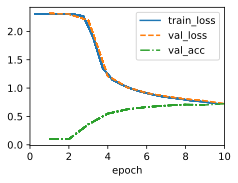

In [88]:
trainer = d2l.Trainer(max_epochs=10, num_gpus=1)
data = d2l.FashionMNIST(batch_size=128)
model = LeNet(lr=0.1)
model.apply_init([next(iter(data.get_dataloader(True)))[0]], init_cnn)
trainer.fit(model, data)

## 8.2 Networks Using Blocks (VGG)

In [10]:
import torch
from torch import nn
from d2l import torch as d2l

### 8.2.1 VGG Blocks

In [11]:
def vgg_block(num_convs, out_channels):
    layers = []
    for _ in range(num_convs):
        layers.append(nn.LazyConv2d(out_channels, kernel_size=3, padding=1))
        layers.append(nn.ReLU())
    layers.append(nn.MaxPool2d(kernel_size=2,stride=2))
    return nn.Sequential(*layers)

### 8.2.2 VGG Network

In [12]:
class VGG(d2l.Classifier):
    def __init__(self, arch, lr=0.1, num_classes=10):
        super().__init__()
        self.save_hyperparameters()
        conv_blks = []
        for (num_convs, out_channels) in arch:
            conv_blks.append(vgg_block(num_convs, out_channels))
        self.net = nn.Sequential(
            *conv_blks, nn.Flatten(),
            nn.LazyLinear(4096), nn.ReLU(), nn.Dropout(0.5),
            nn.LazyLinear(4096), nn.ReLU(), nn.Dropout(0.5),
            nn.LazyLinear(num_classes))
        self.net.apply(d2l.init_cnn)

In [13]:
VGG(arch=((1, 64), (1, 128), (2, 256), (2, 512), (2, 512))).layer_summary((1, 1, 224, 224))

Sequential output shape:	 torch.Size([1, 64, 112, 112])
Sequential output shape:	 torch.Size([1, 128, 56, 56])
Sequential output shape:	 torch.Size([1, 256, 28, 28])
Sequential output shape:	 torch.Size([1, 512, 14, 14])
Sequential output shape:	 torch.Size([1, 512, 7, 7])
Flatten output shape:	 torch.Size([1, 25088])
Linear output shape:	 torch.Size([1, 4096])
ReLU output shape:	 torch.Size([1, 4096])
Dropout output shape:	 torch.Size([1, 4096])
Linear output shape:	 torch.Size([1, 4096])
ReLU output shape:	 torch.Size([1, 4096])
Dropout output shape:	 torch.Size([1, 4096])
Linear output shape:	 torch.Size([1, 10])


### 8.2.3 Training

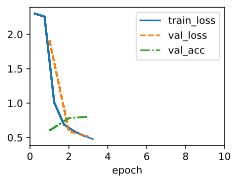

In [ ]:
model = VGG(arch=((1, 16), (1, 32), (2, 64), (2, 128), (2, 128)), lr=0.01)
trainer = d2l.Trainer(max_epochs=10, num_gpus=1)
data = d2l.FashionMNIST(batch_size=128, resize=(224, 224))
model.apply_init([next(iter(data.get_dataloader(True)))[0]], d2l.init_cnn)
trainer.fit(model, data)

## 8.6 Residual Networks (ResNet) and ResNeXt

In [1]:
import torch
from torch import nn
from torch.nn import functional as F
from d2l import torch as d2l

### 8.6.1 Function Classes

### 8.6.2 Residual Blocks

In [2]:
class Residual(nn.Module):  #@save
    """The Residual block of ResNet models."""
    def __init__(self, num_channels, use_1x1conv=False, strides=1):
        super().__init__()
        self.conv1 = nn.LazyConv2d(num_channels, kernel_size=3, padding=1,
                                   stride=strides)
        self.conv2 = nn.LazyConv2d(num_channels, kernel_size=3, padding=1)
        if use_1x1conv:
            self.conv3 = nn.LazyConv2d(num_channels, kernel_size=1,
                                       stride=strides)
        else:
            self.conv3 = None
        self.bn1 = nn.LazyBatchNorm2d()
        self.bn2 = nn.LazyBatchNorm2d()

    def forward(self, X):
        Y = F.relu(self.bn1(self.conv1(X)))
        Y = self.bn2(self.conv2(Y))
        if self.conv3:
            X = self.conv3(X)
        Y += X
        return F.relu(Y)

In [3]:
blk = Residual(3)
X = torch.randn(4, 3, 6, 6)
blk(X).shape

/opt/anaconda3/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


torch.Size([4, 3, 6, 6])

In [4]:
blk = Residual(6, use_1x1conv=True, strides=2)
blk(X).shape

torch.Size([4, 6, 3, 3])

### 8.6.3 ResNet Model

In [5]:
class ResNet(d2l.Classifier):
    def b1(self):
        return nn.Sequential(
            nn.LazyConv2d(64, kernel_size=7, stride=2, padding=3),
            nn.LazyBatchNorm2d(), nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

In [6]:
@d2l.add_to_class(ResNet)
def block(self, num_residuals, num_channels, first_block=False):
    blk = []
    for i in range(num_residuals):
        if i == 0 and not first_block:
            blk.append(Residual(num_channels, use_1x1conv=True, strides=2))
        else:
            blk.append(Residual(num_channels))
    return nn.Sequential(*blk)

In [7]:
@d2l.add_to_class(ResNet)
def __init__(self, arch, lr=0.1, num_classes=10):
    super(ResNet, self).__init__()
    self.save_hyperparameters()
    self.net = nn.Sequential(self.b1())
    for i, b in enumerate(arch):
        self.net.add_module(f'b{i+2}', self.block(*b, first_block=(i==0)))
    self.net.add_module('last', nn.Sequential(
        nn.AdaptiveAvgPool2d((1, 1)), nn.Flatten(),
        nn.LazyLinear(num_classes)))
    self.net.apply(d2l.init_cnn)

In [8]:
class ResNet18(ResNet):
    def __init__(self, lr=0.1, num_classes=10):
        super().__init__(((2, 64), (2, 128), (2, 256), (2, 512)),
                       lr, num_classes)

ResNet18().layer_summary((1, 1, 96, 96))

Sequential output shape:	 torch.Size([1, 64, 24, 24])
Sequential output shape:	 torch.Size([1, 64, 24, 24])
Sequential output shape:	 torch.Size([1, 128, 12, 12])
Sequential output shape:	 torch.Size([1, 256, 6, 6])
Sequential output shape:	 torch.Size([1, 512, 3, 3])
Sequential output shape:	 torch.Size([1, 10])


### 8.6.4 Training

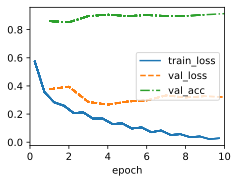

In [9]:
model = ResNet18(lr=0.01)
trainer = d2l.Trainer(max_epochs=10, num_gpus=1)
data = d2l.FashionMNIST(batch_size=128, resize=(96, 96))
model.apply_init([next(iter(data.get_dataloader(True)))[0]], d2l.init_cnn)
trainer.fit(model, data)

## Discussion & Exercise

### 7.1.1 Memo
Pigs usually do not fly and planes usually do not swim.  
Nonetheless, we should still recognize a pig were one to appear at the top of the image.
-> We must be able to find the image we are looking for wherever it is located.  

- translation Invariance: The earliest layers of the network should respond similarly to the same patch, regardless of where it appears in the image. This principle is called translation invariance (or translation equivariance).  

- locality principle: The earliest layers of the network should focus on local regions, without regard for the contents of distant areas in the image. Eventually, these local representations can be aggregated to make predictions at the whole image level.  

- hierarchical feature capture: As the network goes deeper, it should be able to capture longer-range features of the image, similar to how higher-level vision works in nature.  



### 7.1.2 Discussion: Hidden Representation
$
[H]_i,_j = [U]_i,_j + \sum_{k} \sum_{l}[W]_i,_j,_k,_l[X]_k,_l
$  

[H]: Hidden Representation
Hidden representation refers to the intermediate or hidden layers of a neural network where the input data is transformed and processed before reaching the final output layer. It is a set of internal representations or features that capture relevant information about the input data.

### 7.1.2.1 Discussion: Translation Invariance
Translation invariance in convolutional neural networks (CNNs):   
sthe property of CNNs to recognize patterns or features in an input image regardless of their position or location within the image.

shifting in the input X should **simply lead to a shift in the hidden representation H** 
  
$
[H]_i,_j = u + \sum_{a} \sum_{b}[V]_a,_b[X]_{i+a, j+b}
$  

**"CONVOLUTION"**   
This is only possible if V and U **do not actually depend on (i,j)**  
Consequently, the number of parameters required is no longer 10^12 but a much more reasonable 4X10^6



### 7.1.2.2 Locality
Locality in convoulional neural networks (CNNs):  
we should not have to look very far away from location $(i,j)$ in order to glean relevant information to assess what is going on at $[H]_{i,j}$   
$
[H]_i,_j = u + \sum_{a = -\Delta}^{a = \Delta} \sum_{b = -\Delta}^{b = \Delta}[V]_a,_b[X]_{i+a, j+b}
$  

outside some range $|a|>Δ \ \ or \ \ |b|>Δ$ we should set $[V]_{a,b} =0$     
->  the number of parameter: 4Δ2, where Δ is typically smaller than 10.

We might have required billions of parameters to represent just a single layer in an image-processing network, we now typically need just a few hundred, without altering the dimensionality of either the inputs or the hidden representations.

### 7.1.4 Channels
images are not two-dimensional objects but rather third-order tensors,   
characterized by a **height, width, and channel** -> shape 1024×1024×3 pixels  
-> index X as $[X]_{i,j,k}$ and convolutional filter as $[V]_{a,b,c}$   

$
[H]_{i,j,d} = \sum_{a = -\Delta}^{a = \Delta} \sum_{b = -\Delta}^{b = \Delta} \sum_{c} [V]_{a, b, c, d} [X]_{i+a, j+b, c}
$    
hidden representations as **third-order** tensors H   
(We could think of the hidden representations as comprising a number of two-dimensional grids stacked on top of each other.)   

d indexes the output channels in the hidden representations H.  
The subsequent convolutional layer will go on to take a third-order tensor, H, as input.

### 7.2.1 Discussion: The Cross-Correlation Operations

Recall that strictly speaking, convolutional layers are a misnomer, since the operations they express are more accurately described as cross-correlations.   

**cross-correlation**   
mathematical operation that measures the similarity between two signals or sequences as they are shifted relative to each other   
In cross-correlation, the two signals are multiplied together at each position of the shift and then summed up. 
-> providing a measure of similarity or correlation between the two signals
When applied to image processing, it involves sliding a filter or kernel over an input image and computing the similarity between the filter and the corresponding image region.

### 7.2.2 Memo: Convolutional Layers
A convolutional layer cross-correlates the input and kernel and **adds a scalar bias** to produce an output.  

**scalar bias?**   
-> a single constant value that is added to each output channel of the convolutional operation

### 7.2.4 Own Exercise: Learning a Kernel

In [30]:
conv2d = nn.LazyConv2d(1, kernel_size=(1,2), bias=False)

# The two-dimensional convolutional layer uses four-dimensional input and
# output in the format of (example, channel, height, width), where the batch
# size (number of examples in the batch) and the number of channels are both 1
X = X.reshape((1, 1, 6, 8))
Y = Y.reshape((1, 1, 6, 7))
lr = 3e-2 # learning rate

# increasing the number of iteration -> increasing epoch
for i in range(30):
    Y_hat = conv2d(X)
    l = (Y_hat - Y) ** 2
    conv2d.zero_grad()
    l.sum().backward()
    conv2d.weight.data[:] -= lr * conv2d.weight.grad
    if (i+1) % 2 == 0:
        print(f'epoch {i + 1}, loss {l.sum():.3f}')

epoch 2, loss 3.064
epoch 4, loss 0.932
epoch 6, loss 0.328
epoch 8, loss 0.125
epoch 10, loss 0.050
epoch 12, loss 0.020
epoch 14, loss 0.008
epoch 16, loss 0.003
epoch 18, loss 0.001
epoch 20, loss 0.001
epoch 22, loss 0.000
epoch 24, loss 0.000
epoch 26, loss 0.000
epoch 28, loss 0.000
epoch 30, loss 0.000


### 7.2.5 - 7.2.8 Memo

It is noteworthy that since kernels are learned from data in deep learning, the outputs of convolutional layers remain unaffected no matter such layers perform either the strict convolution operations or the cross-correlation operations.   
Therefore in keeping with standard terminology in deep learning literature, we will continue to refer to the cross-correlation operation as a convolution even though, strictly-speaking, it is slightly different.  

As described in Section 7.1.4, the convolutional layer output in Fig. 7.2.1 is sometimes called a **feature map**, as it can be regarded as the learned representations (features) in the spatial dimensions (e.g., width and height) to the subsequent layer.   

The core computation required for a convolutional layer is a **cross-correlation operation**. We saw that a simple nested for-loop is all that is required to compute its value.

### 7.3.1 Memo: Padding
As motivation, note that since kernels generally have width and height greater than 1 , after applying many successive convolutions, we tend to wind up with outputs that are **considerably smaller than our input**. If we start with a 240 X 240 pixel image, ten layers of 5 X 5 convolutions reduce the image to 200 X 200 pixels, slicing off 30% of the image and with it obliterating any interesting information on the boundaries of the original image.

In many cases, we will want to set $p_h = k_h - 1 \ \ and \ \ p_w = k_w - 1$ to give the input and output the same height and width.   

CNNs commonly use convolution kernels with **odd** height and width values, such as 1, 3, 5, or 7.   
Choosing odd kernel sizes has the benefit that we can preserve the dimensionality while padding with the same number of rows on top and bottom, and the same number of columns on left and right.

### 7.3.2 Discussion & Own Exercise: Stride

Sometimes, either for computational efficiency or because we wish to downsample, we move our window more than one element at a time, skipping the intermediate locations. This is particularly **useful if the convolution kernel is large** since it captures a large area of the underlying image.

**Stride?**   
the number of rows and columns traversed per slide
In general, when the stride for the height is $s_h$ and the stride for the width is $s_w$   
the output shape : $\lfloor(n_h - k_h + p_h +s_h) / s_h \rfloor * \lfloor(n_w - k_w + p_w +s_w) / s_w \rfloor $   
set $p_h = k_h - 1 \ \ and \ \ p_w = k_w - 1$   
-> $\lfloor(n_h + s_h - 1) / s_h \rfloor * \lfloor(n_w + s_w - 1) / s_w \rfloor $   
-> $\lfloor n_h / s_h \rfloor * \lfloor n_w / s_w \rfloor $

In [45]:
X = torch.rand(size=(8,8))
conv2d = nn.LazyConv2d(1, kernel_size=7, padding=3, stride=2)
comp_conv2d(conv2d, X)

tensor([[0.3322, 0.0993, 0.3693, 0.1354],
        [0.4983, 0.3620, 0.4311, 0.3449],
        [0.5927, 0.1923, 0.7249, 0.2748],
        [0.3193, 0.1860, 0.2513, 0.3415]], grad_fn=<ReshapeAliasBackward0>)

### 7.4.1 Memo: Multiple Input Channels

When the input data contains multiple channels, we need to construct a convolution kernel with the same number of input channels as the input data, so that it can perform cross-correlation with the input data.  

All we are doing is performing a **cross-correlation operation per channel and then adding up the results**.

### 7.4.3 Discussion: 1X1 Convolutional Layer

X = torch.normal(0, 1, (3, 3, 3))   
-> 3-dimensional tensor that follows a normal distribution with a mean of 0 and a standard deviation of 1, shape: (3, 3, 3)   
K = torch.normal(0, 1, (2, 3, 1, 1))   
-> 4-dimensional tensor that follows a normal distribution with a mean of 0 and a standard deviation of 1, shape: (2, 3, 1, 1)

assert float(torch.abs(Y1 - Y2).sum()) < 1e-6   
-> calculate the absolute difference between Y1 and Y2 and check if their sum is smaller than 1e-6
    (In other words, this is an assertion to verify whether the results of the two operations are almost identical)

### 7.5.1 Discussion: Maximum Pooling and Average Pooling

**pooling** 
- no parameters to learn   
    pooling operations only perform tasks such as extracting the maximum value or calculating the average from the target area

- the number of channels does not change   
    the operations are performed independently for each channel

- less affected by changes in the input   
    pooling operations are less affected by changes in the input
    For example, even if the element values of the input data shift to the right by 1, the result remains the same

### 7.5.2 Memo: Padding and Stride

As with convolutional layers, pooling layers change the output shape. And as before, we can adjust the operation to achieve a desired output shape by padding the input and adjusting the stride. We can demonstrate the use of padding and strides in pooling layers via the built-in two-dimensional max-pooling layer from the deep learning framework.

### 7.6.1 Own Exercise: LeNet

At a high level, LeNet (LeNet-5) consists of two parts   
1) a convolutional encoder consisting of two convolutional layers   
2) a dense block consisting of three fully connected layers    


In [93]:
def init_cnn(module): #@save
    """Initialize weights for CNNs"""
    if type(module) == nn.Linear or type(module) == nn.Conv2d:
        nn.init.xavier_uniform_(module.weight)

# Change activation function from sigmoid to ReLU
class LeNet_relu(d2l.Classifier): #@save
    """The LeNet-5 model"""
    def __init__(self, lr=0.1, num_classes=10):
        super().__init__()
        self.save_hyperparameters()
        self.net = nn.Sequential(
            nn.LazyConv2d(6, kernel_size=5, padding=2), nn.ReLU(),
            nn.AvgPool2d(kernel_size=2, stride=2),
            nn.LazyConv2d(16, kernel_size=5), nn.ReLU(),
            nn.AvgPool2d(kernel_size=2, stride=2),
            nn.Flatten(),
            nn.LazyLinear(120), nn.ReLU(),
            nn.LazyLinear(84), nn.ReLU(),
            nn.LazyLinear(num_classes))

In [94]:
@d2l.add_to_class(d2l.Classifier)  #@save
def layer_summary(self, X_shape):
    X = torch.randn(*X_shape)
    for layer in self.net:
        X = layer(X)
        print(layer.__class__.__name__, 'output shape:\t', X.shape)

model = LeNet_relu()
model.layer_summary((1, 1, 28, 28))

Conv2d output shape:	 torch.Size([1, 6, 28, 28])
ReLU output shape:	 torch.Size([1, 6, 28, 28])
AvgPool2d output shape:	 torch.Size([1, 6, 14, 14])
Conv2d output shape:	 torch.Size([1, 16, 10, 10])
ReLU output shape:	 torch.Size([1, 16, 10, 10])
AvgPool2d output shape:	 torch.Size([1, 16, 5, 5])
Flatten output shape:	 torch.Size([1, 400])
Linear output shape:	 torch.Size([1, 120])
ReLU output shape:	 torch.Size([1, 120])
Linear output shape:	 torch.Size([1, 84])
ReLU output shape:	 torch.Size([1, 84])
Linear output shape:	 torch.Size([1, 10])


### 7.6.2 Own Exercise: Training

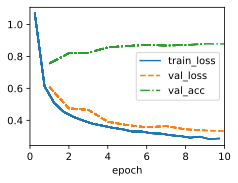

In [95]:
trainer = d2l.Trainer(max_epochs=10, num_gpus=1)
data = d2l.FashionMNIST(batch_size=128)
model = LeNet_relu(lr=0.1)
model.apply_init([next(iter(data.get_dataloader(True)))[0]], init_cnn)
trainer.fit(model, data)

### 8.2.1 Memo: VGG Blocks

**The Visual Geometry Group (VGG)**   
convolutional neural network architecture that was proposed by the Visual Geometry Group at the University of Oxford
VGG is known for its simplicity and effectiveness in image classification tasks.   

VGG architecture consists of    
1) convolutional layers   
2) max-pooling layers   
3) fully connected layers   

The key characteristic of VGG is that it uses a stack of **small-sized convolutional filters (3x3)** with a stride of 1, and always uses the same padding to maintain the spatial resolution of the feature maps. This design choice allows VGG to learn hierarchical representations of visual patterns at different scales.   
VGG is known for its simplicity, strong performance, and ability to learn expressive representations of visual data, making it a popular choice in the field of deep learning for computer vision tasks.    

The basic building block of CNNs is a sequence of the following: 
1) a convolutional layer with padding to maintain the resolution
2) a nonlinearity such as a ReLU
3) a pooling layer such as max-pooling to reduce the resolution
-> One of the problems with this approach is that the spatial resolution decreases quite rapidly.


### 8.6.1 Memo: Function Classes

Consider F, the class of functions that a specific network architecture (together with learning rates and other hyperparameter settings) can reach. That is, for all f∈F there exists some set of parameters (e.g., weights and biases) that can be obtained through training on a suitable dataset.  

we will try to find some $f_{F∗}$ which is our best bet within F.    

For non-nested function classes, a larger function class does not always move closer to the “truth” function f∗.
-> only if larger function classes contain the smaller ones are we guaranteed that increasing them strictly increases the expressive power of the network.

### 8.6.2 Discussion: Residual Blocks

Residual blocks learn residual mappings instead of direct mappings between layers.   
ResNet’s residual blocks consist of two 3×3 convolutional layers, with shortcut connections allowing faster input propagation.   
The output and input must have the same shape for addition, and channel adjustments can be done using a 1×1 convolutional layer.